## 3 Qubit State

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from itertools import product
from functools import reduce
import matplotlib.cm as cm
import scipy

In [125]:
L = 3 # Number of qubits
d = 2**L # Dimension of Hilbert space

Define the Pauli Matrices:

In [126]:
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

Construct a test density matrix: L=2 GHZ state:
$$
| \psi \rangle = \frac{1}{\sqrt{2}} ( |000 \rangle + |111\rangle)
$$

$$
\rho = | \psi \rangle \langle \psi |
$$
todo graph on 3d bar plot

In [127]:
psi = np.zeros(2**L)
psi[0] = 1/np.sqrt(2)
psi[-1] = 1/np.sqrt(2)
rho = np.outer(psi, psi)

In [128]:
rho

array([[0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0.5],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0.5]])

Text(0.5, 0, '$|\\rho_{jk}|$')

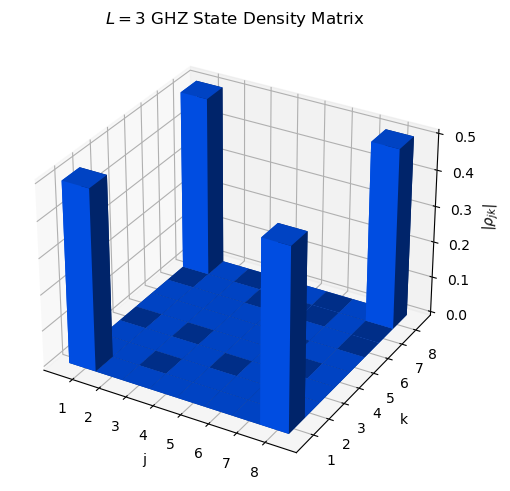

In [141]:
fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(projection="3d")

_x = np.arange(0.5, d + .5, 1)
_y = np.arange(0.5, d + .5, 1)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = np.abs(rho).ravel()
bottom = np.zeros_like(top)
width = depth = 1

# amplitudes = np.abs(rho)
phases = np.angle(rho)

# ax.bar3d(x, y, bottom, width, depth, top, shade=True)
ax.bar3d(x, y, bottom, width, depth, top, shade=True, color=plt.cm.hsv((3.9 + phases.flatten())/(2*np.pi)))

ax.set_title("$L = 3$ GHZ State Density Matrix")
ax.set_xlabel("j")
ax.set_ylabel("k")
ax.set_zlabel(r"$|\rho_{jk}|$")


todo add random complex phases and get colored visualization

In [130]:
# Define Pauli Matrices
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
paulis = np.array([X, Y, Z])

def get_projectors(measure_settings: np.ndarray):
    """
    Parameters:
        measure_settings: m by L array of 0, 1, or 2 determining Pauli basis
            where m is number of measurement settings
    Returns:
        mxd array of random Pauli basis projectors,
        i.e. returns list of P_k for eigenspace projectors P_k
    """
    eigvecs = np.array([ np.linalg.eig(sigma).eigenvectors for sigma in paulis ])
    # Number of qubits
    m = measure_settings.shape[0]
    d = 2**measure_settings.shape[1] # d = 2^L

    # Set of dxd projectors for each basis for each measurement setting
    P = np.zeros((m, d, d, d), dtype="complex128")

    for j, pauli_idx in enumerate(measure_settings):

        pauli_eigs_l = eigvecs[pauli_idx]

        # Get all combinations of 1 eigenvector from each pauli across L paulis
        eigs_sets = list(product(*pauli_eigs_l)) # 2^L total

        for k, set in enumerate(eigs_sets):
            # Tensor product all eigenvectors
            v_k = reduce(np.kron, set)
            # Form projector onto eigenspace
            proj_k = np.outer(np.conj(v_k), v_k)
            P[j, k, :, :] = proj_k

    return P

In [131]:
def sampling_operator(U: np.ndarray, Pk: np.ndarray):
    """
    Parameters:
        U: dxd density matrix
        Pk: m x d x d x d array of projection operators
    Returns:
        A(U) = [ [tr(UP_1), ...], ..., [..., tr(UP_md)] ]
    """
    return np.array([[
            np.real(np.trace(P @ U)) for P in P_setting ]
        for P_setting in Pk ])

In [132]:
N = 100 # Num. of measurement repeats
m = 15 # Num. of measurement settings
measures_test = np.random.randint(0, 3, size=(m, L))

In [133]:
proj_k = get_projectors(measures_test)

Generate some noisy measurements:

In [134]:
# Each measurement setting defines a new basis which is some multinomial distribution
probabilities = sampling_operator(rho, proj_k)
samples = np.array([ np.random.multinomial(N, basis_probs) for basis_probs in probabilities ])

# Normalize and flatten
Y = samples.flatten() / N

## Convex problem

$$
\min_X ||X||_{*} \quad \mathrm{s.t.} \: X \succcurlyeq 0, ||\mathcal{A}(X) - \mathcal{Y}||_2 ^2 \leq \varepsilon
$$

In [135]:
epsilon = 0.35
proj_flat = proj_k.reshape(proj_k.shape[0]*proj_k.shape[1], d, d)
md = proj_k.shape[0]*proj_k.shape[1]

X = cp.Variable((d, d), complex=True)

AX = cp.reshape(cp.vstack([cp.trace(proj_flat[i] @ X) for i in range(md)]), (md))
constraints = [X >> 0]

constraints += [cp.norm(AX - Y) <= epsilon]

prob = cp.Problem(cp.Minimize(cp.normNuc(X)),   
                  constraints)
prob.solve()

0.9405224897779232

Text(0.5, 0, '$|\\rho_{jk}|$')

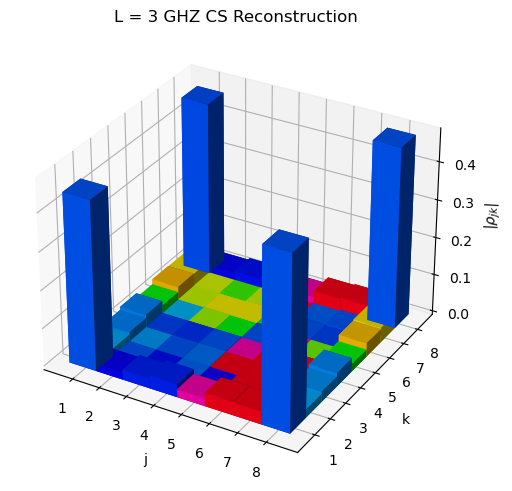

In [140]:
from matplotlib.colors import Normalize

fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(projection="3d")
_x = np.arange(0.5, d + .5, 1)
_y = np.arange(0.5, d + .5, 1)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

cs_sltn = X.value
amplitudes = np.abs(cs_sltn)
phases = np.angle(cs_sltn)

top = amplitudes.ravel()
bottom = np.zeros_like(top)
width = depth = 1


ax.bar3d(x, y, bottom, width, depth, top, shade=True, color=plt.cm.hsv((3.9 + phases.flatten())/(2*np.pi)))
ax.set_title("L = 3 GHZ CS Reconstruction")
ax.set_xlabel("j")
ax.set_ylabel("k")
ax.set_zlabel(r"$|\rho_{jk}|$")

# fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(3.9, 3.9+2*np.pi), cmap=plt.cm.hsv))

Text(0.5, 0.98, '$L=3$ GHZ State')

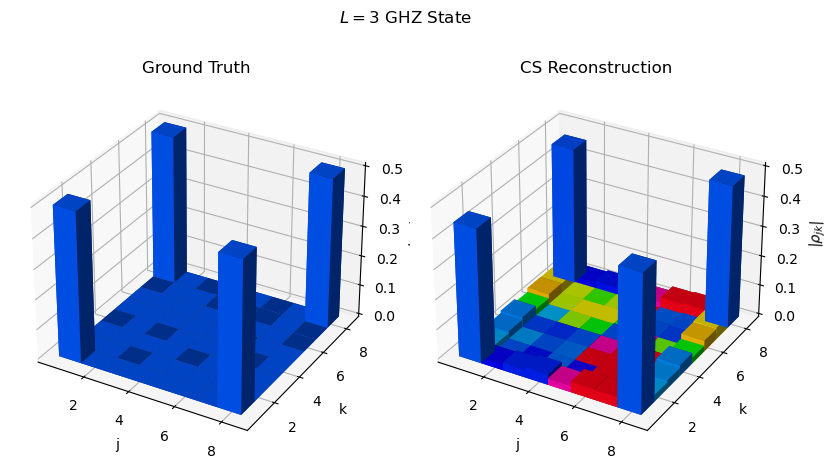

In [137]:
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(8,5), constrained_layout=True)
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")

_x = np.arange(0.5, 8.5, 1)
_y = np.arange(0.5, 8.5, 1)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = np.abs(rho).ravel()
angle = np.angle(rho).ravel()

top_cs = np.abs(cs_sltn).ravel()
angle_cs = np.angle(cs_sltn).ravel()

bottom = np.zeros_like(top)
width = depth = 1

ax1.bar3d(x, y, bottom, width, depth, top, shade=True, color=plt.cm.hsv((3.9 + angle.flatten())/(2*np.pi)))
ax1.set_title("Ground Truth")
ax1.set_xlabel("j")
ax1.set_ylabel("k")
ax1.set_zlabel(r"$|\rho_{jk}|$")

ax2.bar3d(x, y, bottom, width, depth, top_cs, shade=True, color=plt.cm.hsv((3.9 + angle_cs.flatten())/(2*np.pi)))
ax2.set_title("CS Reconstruction")
ax2.set_zlim(0, 0.5)
ax2.set_xlabel("j")
ax2.set_ylabel("k")
ax2.set_zlabel(r"$|\rho_{jk}|$")

ticks = np.linspace(0, 2 * np.pi, num=5)
fig.suptitle("$L=3$ GHZ State")
# cb = fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(0, 2*np.pi, ), cmap=plt.cm.hsv), orientation="horizontal",
#              location="bottom", ax=[ax1, ax2], aspect=25, label=r"$\phi$")
# # cb.set_ticks(ticks)


### Fidelity
$$
F(\rho, \sigma) \equiv \mathrm{tr}(\sqrt{\rho^{1/2} \sigma \rho^{1/2}})
$$

In [138]:
def fidelity(rho, sigma):
    """Returns the fidelity between the two states"""
    sqrt_rho = scipy.linalg.sqrtm(rho)
    return np.real(np.trace(scipy.linalg.sqrtm(sqrt_rho @ sigma @ sqrt_rho)))

In [139]:
fidelity(X.value, rho)

0.9589406007795078315

In [ ]:


# n_msettings = np.arange(m_min, m_max, 1)
# fidelities = np.zeros(len(n_msettings))

# i = 0
# for m in n_msettings:
#     cs.run(100, m, epsilon=0.5)
#     fidelities[i] = cs.get_fidelity()
#     i += 1


# fig, ax = plt.subplots()
# ax.plot(n_msettings, fidelities)
# ax.scatter(n_msettings, fidelities)
# ax.set_ylim(0, 1)
# ax.set_xlabel("m")
# ax.set_ylabel("F")
# ax.set_title(r"Compressed Sensing, L=3 GHZ, $\epsilon = 0.5$")
# plt.show()